# All Noise No Signal: SGD is Asymptotically Brownian

[Previously, I made the claim that singularities translate random motion at the bottom of loss basins into search for generalization](https://www.lesswrong.com/posts/2N7eEKDuL5sHQou3N/spooky-action-at-a-distance-in-the-loss-landscape). Complex singularities corresponding to simple functions "trap" the random motion, and these simple functions generalize better.

Let's put that claim to the test. 

In particular, can we make models with low training error but high test error generalize simply by exploring the set of low loss points? In particular, if you take a pre-grokked model, can you make it grok via Hamiltonian MC once it's reached a minimum loss point?

Here's the proposal: given a starting choice of weights $\mathbf w \in \mathbb R^d$, explore the nearby space using Hamiltonian MC (or something fancier like NUTS). That is:
1. Sample a momentum $\mathbf p \sim \mathcal N(0, \boldsymbol I_{d\times d})$.
2. Evolve according to the equations of motion, where we treat the loss over either (1) a batch or (2) the entire test set as the energy.
3. Compare to the model obtained by training normally (via minibatch SGD/full-batch GD) in terms of test loss.  

If my hypothesis is right, then we should expect the model to become more general even when we're no longer explicitly optimizing it (for better training loss / lower weight norms).


Thanks to [Marius Hobbhahn](https://www.lesswrong.com/users/marius-hobbhahn) and [Neel Nanda](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20) for their grokking code.

In [1]:
!nvidia-smi
!pip install einops 

zsh:1: command not found: nvidia-smi

[notice] A new release of pip available: 22.2.2 -> 23.0
[notice] To update, run: pip install --upgrade pip


# Set-up

## Imports

In [2]:
import random
import time
from pathlib import Path
import pickle
import os
import copy
from collections import OrderedDict
import functools
import itertools
import gc

import numpy as np
import matplotlib.pyplot as plt
import einops
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import pandas as pd

# pio.renderers.default = "colab"
# %matplotlib inline

## Hyperparameters

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


In [4]:
lr=1e-3 #@param
weight_decay = 0.1 #@param 
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
frac_train = 0.3 #@param
NUM_EPOCHS = 1000 #@param
save_models = False #@param
save_every = 100 #@param
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param
seed = 0 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1 
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
#batch_size = BATCH_SIZE

## Architecture

In [5]:
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)


class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]


class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x


class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        
    def forward(self, x):
        k = torch.einsum('ihd,bpd->biph', self.W_K, x)
        q = torch.einsum('ihd,bpd->biph', self.W_Q, x)
        v = torch.einsum('ihd,bpd->biph', self.W_V, x)
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = F.softmax(attn_scores_masked/np.sqrt(self.d_head), dim=-1)
        z = torch.einsum('biph,biqp->biqh', v, attn_matrix)
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out


class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in
        
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x


class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
    
    def forward(self, x):
        x = x + self.attn(x)
        x = x + self.mlp((x))
        return x


class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_ln=True):
        super().__init__()

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x


In [6]:
def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch  
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

In [7]:
## set torch seed 
SEED = 0
torch.manual_seed(SEED)

# Data

As described in Neel's post, every input sequence is of the form `(i, j, num)` where the target is `i+j mod num`

In [8]:
def gen_train_test(frac_train = 0.3, num = 113, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train_x, test_x = gen_train_test(frac_train, 113, seed=0)
print(len(train_x), len(test_x))

print(train_x[:10])
print(test_x[:10])

3830 8939
[(18, 34, 113), (10, 83, 113), (55, 28, 113), (25, 51, 113), (63, 65, 113), (14, 104, 113), (27, 56, 113), (35, 77, 113), (41, 72, 113), (17, 111, 113)]
[(50, 67, 113), (92, 107, 113), (29, 14, 113), (76, 53, 113), (78, 80, 113), (77, 58, 113), (97, 1, 113), (39, 59, 113), (95, 73, 113), (38, 40, 113)]


In [9]:
### create training and test samples in batches

def collate_batch(batch):
    label_list = [(i+j) % num for (i,j,num) in batch]
    label_list = torch.tensor(label_list, dtype=torch.int64)
    input_list = [torch.tensor(x) for x in batch]
    input_list = torch.cat(input_list).view(len(label_list), -1)
    return input_list.to(DEVICE), label_list.to(DEVICE)

# one batch per loader
train_loader = DataLoader(train_x, batch_size=len(train_x), collate_fn=collate_batch)
test_loader = DataLoader(test_x, batch_size=len(test_x), collate_fn=collate_batch)

print(len(train_loader))
for x, y in train_loader:
    print(x[:10])
    print(y[:10])

1
tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]])
tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15])


In [10]:
def loss_of_final_number(logits, labels):
    # only look at predictions of last numbers
    logits = logits[:,-1]
    # compute individual and summed losses for final number
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels.unsqueeze(1), dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

# Training

In [43]:
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, 
                    d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_ln=False).to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

In [45]:
# train
train_losses = []
test_losses = []
train_accs = []
test_accs = []

weights_epochs = {}
grads_epochs = {}

for i in trange(NUM_EPOCHS, desc="Epoch"):
    final_digit_loss = 0
    for j, (x, y) in enumerate(train_loader):

        optimizer.zero_grad()
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        train_loss = loss_of_final_number(out, y)
        sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
        correct = (y == sm_argmax.view(-1)).detach()

        train_loss.backward()
        optimizer.step()

        final_digit_loss += train_loss.item()

    scheduler.step()
    train_losses.append(final_digit_loss)
    train_accs.append(correct.float().mean().item())

    if i % save_every == 0:
        print("epoch {}; training loss {};".format(i, final_digit_loss))
        print("training acc {};".format(correct.float().mean()))
        # run a test every N iterations
        for x, y in test_loader:

            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            test_loss = loss_of_final_number(out, y)
            sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
            correct = (y == sm_argmax.view(-1)).detach()

        print("test loss: {}".format(test_loss.item()))
        print("test acc: {}".format(correct.float().mean()))
        test_losses.append(test_loss.item())
        test_accs.append(correct.float().mean().item())

        print("\n")

        # store the weights
        weights_epochs["weights_epoch_{}".format(i)] = copy.deepcopy(model.state_dict())

        # get and store gradients
        gradient_dict = OrderedDict()
        for name, param in model.named_parameters():
            gradient_dict["grad_{}".format(name)] = copy.deepcopy(param.grad)

        grads_epochs["grads_epoch_{}".format(i)] = gradient_dict


Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0; training loss 4.773319524005533;
training acc 0.009660574607551098;
test loss: 4.77188949513312
test acc: 0.008949547074735165


epoch 100; training loss 1.9623976399313452;
training acc 0.5438642501831055;
test loss: 7.800757557981267
test acc: 0.05973822623491287


epoch 200; training loss 0.0050438199501800516;
training acc 1.0;
test loss: 17.254595311044955
test acc: 0.18301823735237122


epoch 300; training loss 0.0013440864062045448;
training acc 1.0;
test loss: 19.0177789492313
test acc: 0.19308647513389587


epoch 400; training loss 0.0004036355514643523;
training acc 1.0;
test loss: 20.606240596609727
test acc: 0.2020360231399536


epoch 500; training loss 0.00012540983364308275;
training acc 1.0;
test loss: 22.13675208863424
test acc: 0.2077413648366928


epoch 600; training loss 3.990044573847931e-05;
training acc 1.0;
test loss: 23.623195682844766
test acc: 0.21188051998615265


epoch 700; training loss 1.2967398023720146e-05;
training acc 1.0;
test loss: 25.075477

In [47]:
## did it learn the training dist?
for x, y in train_loader:
    out = model(x.to(DEVICE))
    sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:10, -1].detach()
    input = x[:10, :]
    print(x.size())
    print("input: ", input)
    label = y[:10]
    print("label: ", label[:10])
    print("argmax prediction: ", sm_argmax)
    print("same: ", label[:10] == sm_argmax)
    break

torch.Size([3830, 3])
input:  tensor([[ 18,  34, 113],
        [ 10,  83, 113],
        [ 55,  28, 113],
        [ 25,  51, 113],
        [ 63,  65, 113],
        [ 14, 104, 113],
        [ 27,  56, 113],
        [ 35,  77, 113],
        [ 41,  72, 113],
        [ 17, 111, 113]])
label:  tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15])
argmax prediction:  tensor([ 52,  93,  83,  76,  15,   5,  83, 112,   0,  15])
same:  tensor([True, True, True, True, True, True, True, True, True, True])


In [48]:
## test stuff

for x, y in test_loader:
    out = model(x.to(DEVICE))
    sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:10, -1].detach()
    input = x[:10, :]
    print(x.size())
    print("input: ", input)
    label = y[:10]
    print("label: ", label[:10])
    print("argmax prediction: ", sm_argmax)
    print("same: ", label[:10] == sm_argmax)
    break

torch.Size([8939, 3])
input:  tensor([[ 50,  67, 113],
        [ 92, 107, 113],
        [ 29,  14, 113],
        [ 76,  53, 113],
        [ 78,  80, 113],
        [ 77,  58, 113],
        [ 97,   1, 113],
        [ 39,  59, 113],
        [ 95,  73, 113],
        [ 38,  40, 113]])
label:  tensor([ 4, 86, 43, 16, 45, 22, 98, 98, 55, 78])
argmax prediction:  tensor([ 74,  86,  92,  33,  45,  91,  87, 112,  98,  68])
same:  tensor([False,  True, False, False,  True, False, False, False, False, False])


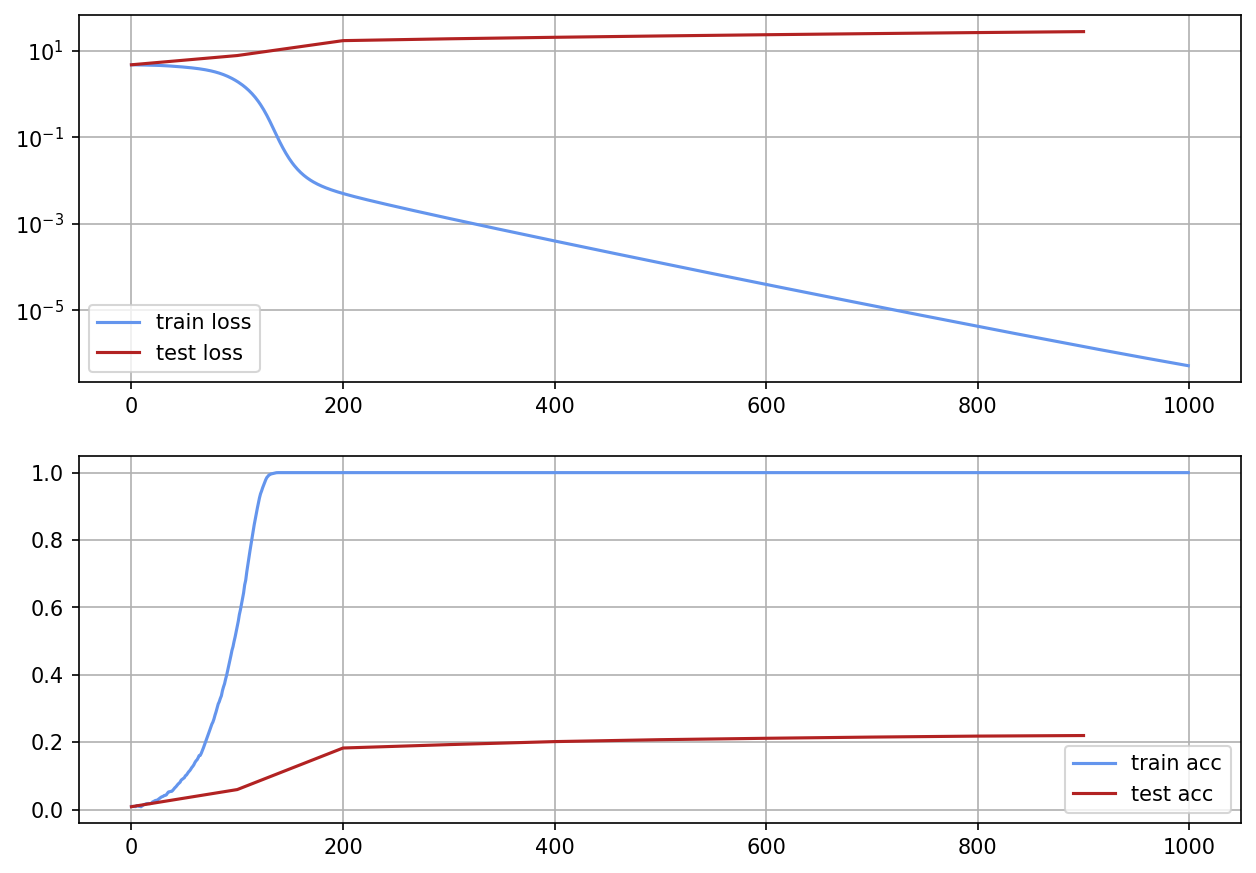

In [49]:
## plot the training and test loss
x_train = np.arange(len(train_losses)) 
x_test = np.arange(len(test_losses)) * save_every
 
fig, ax = plt.subplots(2,1,figsize=(10, 7), dpi=150)

ax[0].grid()
ax[0].plot(x_train, train_losses, color="cornflowerblue", label="train loss")
ax[0].plot(x_test, test_losses, color="firebrick", label="test loss")
ax[0].legend()
ax[0].set_yscale("log")

ax[1].grid()
ax[1].plot(x_train, train_accs, color="cornflowerblue", label="train acc")
ax[1].plot(x_test, test_accs, color="firebrick", label="test acc")
ax[1].legend()

plt.show()

# Let's inject some noise

At this point, the model has excellent training loss, but terrible test loss. 

Let's continue with four variants:
1. Train with Adam but no weight decay
2. Train with Adam and weight decay
3. Hamiltonian MC with no weight decay
4. Hamiltonian MC with weight decay

In [51]:
# Save a checkpoint

checkpoint = model.state_dict()
path = Path("grokking/checkpoint-1000.pt")
path.parent.mkdir(parents=True, exist_ok=True)
torch.save(checkpoint, path)    

In [11]:
from typing import Optional


class HMC(optim.Optimizer):
    start_loss: Optional[torch.Tensor] = None

    def __init__(self, params, lr=1e-3, weight_decay=0., beta=0.9, mass=1.) -> None:
        super().__init__(params, dict(lr=lr, weight_decay=weight_decay, beta=beta, mass=mass))
        
        self.hyperparams = dict(lr=lr, weight_decay=weight_decay, beta=beta, mass=mass)
        self.params = self.param_groups[0]['params']

        self.start = None
        self.start = self.new_start()
        
        self.momentum = self.sample_momentum()
        self.start_loss = None
        self._step = 0

    def step(self, loss: torch.Tensor):
        # TODO: Consider leapfrogging (my guess is that most of the error comes from the minibatch approximation)
        
        if self.start_loss is None:
            self.start_loss = loss.clone()
        
        self.momentum 

        for m, p in zip(self.momentum, self.params):
            m.data.sub_((self.hyperparams['lr']) * (p.grad + self.hyperparams['weight_decay'] * p))
            p.data.add_(m * self.hyperparams['lr'] / self.hyperparams['mass'])

        self._step += 1

    def mh_check(self, loss: torch.Tensor):
        # Metropolis-Hasting acceptance step to account for numerical error + approximation over minibatch
        is_accepted = torch.rand(1) < torch.exp(self.start_loss - loss)
        
        if is_accepted:
            self.new_start()
            self.start_loss = loss.clone()
            self.momentum = self.sample_momentum()
        else:
            self.restart()

        return is_accepted

    def new_start(self):
        """Start a new trajectory at the current params"""
        if self.start is None:
            self.start = tuple((
                p.data.clone().detach()
                for p in self.params
            ))
        else:
            for p, start in zip(self.params, self.start):
                start.data = p.data

        return self.start
    
    def restart(self):
        """Restart the current params to the start of the current trajectory"""
        for p, start in zip(self.params, self.start):
            p.data = start
        
    def sample_momentum(self):
        """Sample a new momentum vector from a standard normal distribution with variance beta"""
        return tuple(
            torch.randn(p.shape) * self.hyperparams['beta']
            for p in self.params
        )

In [13]:
checkpoint = torch.load("grokking/checkpoint-1000.pt")

# Make the variants
kwargs = dict(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp,
              d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_ln=False)

model = Transformer(**kwargs)
model.load_state_dict(checkpoint)

adam_no_wd = copy.deepcopy(model)
adam_wd = copy.deepcopy(model)
hmc_no_wd = copy.deepcopy(model) 
hmc_wd = copy.deepcopy(model)

models = [adam_no_wd, adam_wd, hmc_no_wd, hmc_wd]
model_names = ["Adam", "Adam_WD", "HMC", "HMC_WD"]

optimizers = [
    optim.AdamW(adam_no_wd.parameters(), lr=lr, weight_decay=0, betas=(0.9, 0.98)),
    optim.AdamW(adam_no_wd.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98)),
    HMC(hmc_no_wd.parameters(), lr=lr, weight_decay=0, beta=0.9),
    HMC(hmc_no_wd.parameters(), lr=lr, weight_decay=weight_decay, beta=0.9)
]

schedulers = [
    optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step / 10, 1))
    for optimizer in optimizers
]


In [15]:
n_epochs = 10000

# train
_df_full = [
    {"model": name, "epoch": i, "L_train": 0, "acc_train": 0, "L_train_with_wd": 0, "L_test": 0, "acc_test": 0, "L_test_with_wd": 0, "wd": 0}
    for i in range(n_epochs // save_every)
    for name, model in zip(model_names, models)
]

_df_min = [
    {"model": name, "epoch": i, "L_train": 0, "acc_train": 0}
    for i in range(n_epochs)
    for name, model in zip(model_names, models)
]

df_full = pd.DataFrame(_df_full)
df_min = pd.DataFrame(_df_min)

In [16]:
def wd(model: nn.Module, l=weight_decay):
    return sum((p.norm() ** 2 for p in model.parameters())).item() * l

train_loss = np.zeros(len(models))
train_correct = np.zeros(len(models))

accepted_epochs = np.zeros(2)
save_every = 10

for i in trange(n_epochs, desc="Epoch"):
    train_loss *= 0
    train_correct *= 0

    for j, (x, y) in enumerate(train_loader):
        for k, (model, opt) in enumerate(zip(models, optimizers)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            out = model(x)
            batch_loss = loss_of_final_number(out, y)
            sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
            
            batch_loss.backward()

            if k < 2:
                opt.step()
            else:
                opt.step(batch_loss)

            opt.zero_grad()
            
            train_correct[k] += (y == sm_argmax.view(-1)).sum().item()
            train_loss[k] += batch_loss.item()

    accepted_epochs[0] += 1. * optimizers[2].mh_check(torch.tensor(train_loss[2]))
    accepted_epochs[1] += 1. * optimizers[3].mh_check(torch.tensor(train_loss[3]))

    for k, (model, scheduler) in enumerate(zip(models, schedulers)):
        df_min.loc[i * len(models) + k, "L_train"] = train_loss[k] / len(train_loader)
        df_min.loc[i * len(models) + k, "acc_train"] = train_correct[k] / len(train_loader)
        
        scheduler.step()

    if i % save_every == 0:
        I = (i // save_every)
        
        test_loss = np.zeros(len(models))
        test_correct = np.zeros(len(models))

        # run a test every N iterations
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            for k, model in enumerate(models):
                out = model(x)
                sm_argmax = nn.functional.softmax(out, dim=-1).argmax(dim=-1)[:, -1].detach()
                
                test_loss[k] += loss_of_final_number(out, y).item()
                train_correct[k] += (y == sm_argmax.view(-1)).sum().detach().item()
        
        for k, model in enumerate(models):
            df_full.loc[I * len(models) + k, "L_train"] = train_loss[k] / len(train_loader)
            df_full.loc[I * len(models) + k, "acc_train"] = train_correct[k] / len(train_loader)
            df_full.loc[I * len(models) + k, "L_test"] = test_loss[k] / len(test_loader)
            df_full.loc[I * len(models) + k, "acc_test"] = test_correct[k] / len(test_loader)
            df_full.loc[I * len(models) + k, "wd"] = wd(model)
            df_full.loc[I * len(models) + k, "L_train_with_wd"] = df_full.loc[I * len(models) + k, "L_train"] + df_full.loc[I * len(models) + k, "wd"]
            df_full.loc[I * len(models) + k, "L_test_with_wd"] = df_full.loc[I * len(models) + k, "L_test"] + df_full.loc[I * len(models) + k, "wd"]

        print(f"Epoch {i}")
        print("# accepted epochs: ", accepted_epochs)
        print(df_full.loc[I * len(models): (I + 1) * len(models) - 1, ["model", "L_train", "acc_train", "L_test", "acc_test", "wd"]])

        # Plot the metrics for all the epochs so far (compare models on same plots)
        # L_train next to L_loss; acc_train next to acc_test; L_train_with_wd next to L_test_with_wd; wd (2x width)

        fig, axes = plt.subplots(4, 2, figsize=(12, 12))
        axes_flattened = [ax for axes_row in axes for ax in axes_row]

        for ax, metric in zip(axes_flattened, ["L_train", "L_test", "acc_train", "acc_test", "L_train_with_wd", "L_test_with_wd", "wd"]):
            for name, model in zip(model_names, models):
                model_data = df_full.copy().loc[df_full.model == name].loc[df_full.epoch <= I]
                xs = model_data.epoch * save_every
                ys = model_data[metric]
                ax.plot(xs, ys, label=name)
            
            ax.set_title(metric)
            ax.legend()

        fig.show()



Epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0
# accepted epochs:  [1. 1.]
     model       L_train  acc_train     L_test  acc_test          wd
0     Adam  5.221386e-07       5812  29.162167         0  472.883398
1  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
2      HMC  5.221386e-07       5833  29.161891         0  472.908936
3   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 10
# accepted epochs:  [11. 11.]
     model       L_train  acc_train     L_test  acc_test          wd
4     Adam  3.297989e-07       5820  30.052455         0  476.040479
5  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
6      HMC  1.534938e-06       5784  29.296617         0  473.324854
7   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 20
# accepted epochs:  [21. 21.]
      model       L_train  acc_train     L_test  acc_test          wd
8      Adam  1.450784e-07       5832  31.234560         0  480.031689
9   Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
10      HMC  4.753735e-06       5775  29.342393         0  473.627295
11   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 30
# accepted epochs:  [31. 31.]
      model       L_train  acc_train     L_test  acc_test          wd
12     Adam  8.838241e-08       5834  31.939215         0  482.212598
13  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
14      HMC  1.691970e-05       5785  29.458912         0  473.970215
15   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 40
# accepted epochs:  [41. 41.]
      model       L_train  acc_train     L_test  acc_test          wd
16     Adam  6.589974e-08       5842  32.346176         0  483.322656
17  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
18      HMC  4.304612e-05       5765  29.487212         0  474.304834
19   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 50
# accepted epochs:  [51. 51.]
      model       L_train  acc_train     L_test  acc_test          wd
20     Adam  5.499165e-08       5841  32.590726         0  483.855566
21  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
22      HMC  8.264582e-05       5758  29.541321         0  474.647363
23   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 60
# accepted epochs:  [61. 61.]
      model       L_train  acc_train     L_test  acc_test          wd
24     Adam  4.877084e-08       5845  32.747226         0  484.082129
25  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
26      HMC  2.104332e-04       5723  29.636132         0  475.052441
27   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 70
# accepted epochs:  [71. 71.]
      model       L_train  acc_train     L_test  acc_test          wd
28     Adam  4.471912e-08       5846  32.855726         0  484.140479
29  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
30      HMC  6.823377e-04       5710  29.682954         0  475.354004
31   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 80
# accepted epochs:  [81. 81.]
      model       L_train  acc_train     L_test  acc_test          wd
32     Adam  4.181175e-08       5850  32.935748         0  484.100293
33  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
34      HMC  1.996109e-03       5681  29.706035         0  475.790527
35   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 90
# accepted epochs:  [91. 91.]
      model       L_train  acc_train     L_test  acc_test          wd
36     Adam  3.958422e-08       5852  32.997487         0  483.997461
37  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
38      HMC  2.692414e-03       5642  29.849197         0  476.230469
39   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 100
# accepted epochs:  [101. 101.]
      model       L_train  acc_train     L_test  acc_test          wd
40     Adam  3.779650e-08       5852  33.046343         0  483.850928
41  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
42      HMC  4.197217e-03       5659  29.870858         0  476.567773
43   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 110
# accepted epochs:  [111. 111.]
      model       L_train  acc_train     L_test  acc_test          wd
44     Adam  3.632596e-08       5852  33.085918         0  483.671826
45  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
46      HMC  7.341858e-03       5641  29.913695         0  476.969434
47   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 120
# accepted epochs:  [121. 121.]
      model       L_train  acc_train     L_test  acc_test          wd
48     Adam  3.508690e-08       5852  33.117936         0  483.466748
49  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
50      HMC  1.147506e-02       5614  29.984886         0  477.282861
51   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 130
# accepted epochs:  [131. 131.]
      model       L_train  acc_train     L_test  acc_test          wd
52     Adam  3.403181e-08       5852  33.144025         0  483.240869
53  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
54      HMC  1.782501e-02       5595  30.086535         0  477.700293
55   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 140
# accepted epochs:  [141. 141.]
      model       L_train  acc_train     L_test  acc_test          wd
56     Adam  3.312480e-08       5853  33.164725         0  482.997314
57  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
58      HMC  2.756809e-02       5562  30.164482         0  478.000049
59   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 150
# accepted epochs:  [151. 151.]
      model       L_train  acc_train     L_test  acc_test          wd
60     Adam  3.234412e-08       5854  33.180899         0  482.738672
61  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
62      HMC  4.713847e-02       5493  30.301990         0  478.382422
63   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Epoch 160
# accepted epochs:  [161. 161.]
      model       L_train  acc_train     L_test  acc_test          wd
64     Adam  3.165873e-08       5856  33.193219         0  482.467285
65  Adam_WD  5.221386e-07       5812  29.162167         0  472.883398
66      HMC  5.420325e-02       5460  30.431012         0  478.797314
67   HMC_WD  5.221386e-07       5812  29.162167         0  472.883398


/var/folders/pw/6c492xhs4299155z1pvbwt8w0000gn/T/ipykernel_93492/2350782389.py:89: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


KeyboardInterrupt: 